In [2]:
# Napokkal kapcsolatos adatok elemzése

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

In [4]:
data = pd.read_csv("cleaned_hotel_bookings.csv")

# Adatelemzés megkezdése
NÉHÁNY MONDAT EZ MIÉRT FONTOS ÉS MI IS VALÓJÁBAN(https://medium.com/swlh/exploratory-data-analysis-what-is-it-and-why-is-it-so-important-part-1-2-240d58a89695)

Hipotézis: Minél távolabb foglalják a foglalást az érkezés dátumához képest annál nagyobb valőszínűséggel mondják le.

In [5]:
pd.pivot_table(data, values = "lead_time", index = "is_canceled") 

,lead_time
is_canceled,
0,79.984687
1,144.848815


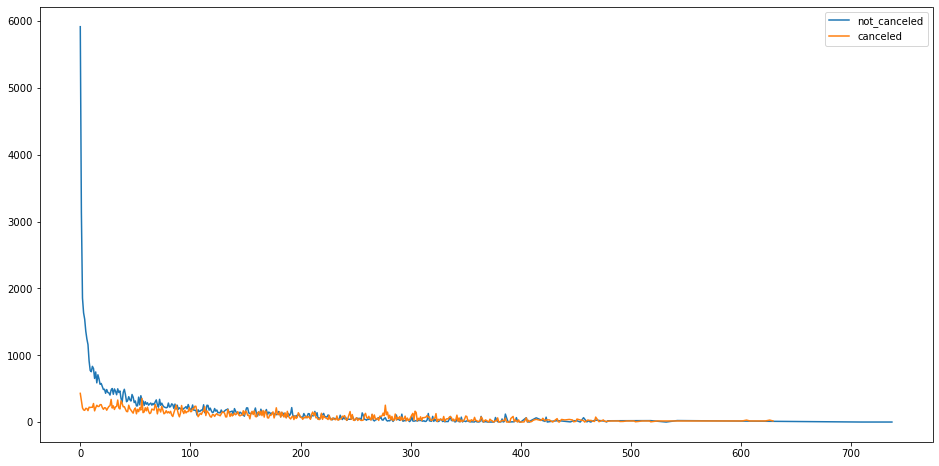

In [72]:
not_canceled = data.loc[data["is_canceled"] == 0].sort_values(by="lead_time", axis=0)
canceled = data.loc[data["is_canceled"] == 1].sort_values(by="lead_time", axis=0)
not_canceled_count = not_canceled.groupby("lead_time").agg("count")
canceled_count = canceled.groupby("lead_time").agg("count")
plt.figure(figsize=(16, 8))
plt.plot(not_canceled_count["hotel"].index, not_canceled_count["hotel"], label="not_canceled")
plt.plot(canceled_count["hotel"].index, canceled_count["hotel"], label="canceled")
plt.legend(loc='upper right')
plt.show()

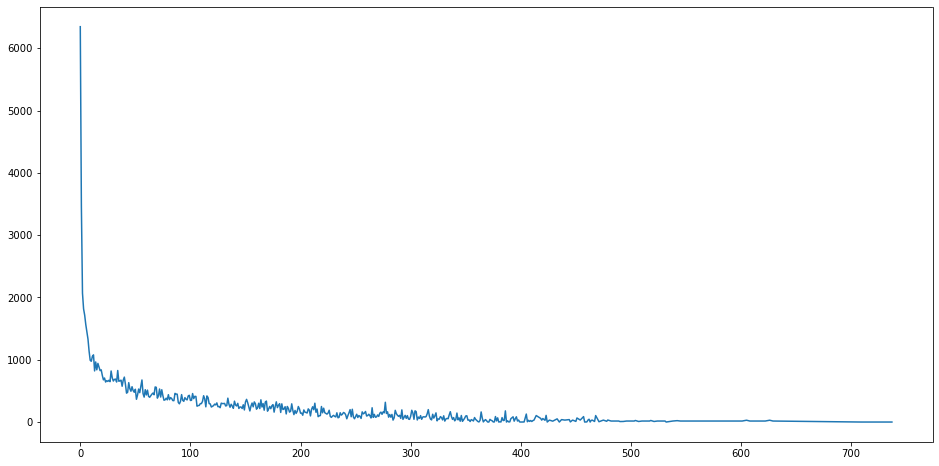

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(data.groupby("lead_time").agg("count")["hotel"].index, data.groupby("lead_time").agg("count")["hotel"])
plt.show()

1 azt mutatja, hogy a foglalást lemondták, a 0 pedig azt, hogy nem.

A pivot tábla alapján láthatjuk, hogy a lemondott foglalásoknak kétszer nagyobb a lead_time-ja mint azoknak amiket nem mondtak le. Ebből következtethetnénk arra, hogy minél nagyobb a lead_time annál nagyobb valószínűséggel mondják le. Azonban ha csinálunk egy vonaldiagramot amiben szétszedjük a lemondott és nem lemondott foglalásokat, csoportosítjuk lead_time szerint és megszámoljuk ezeket, rögtön kitűnik, hogy a két diagram a kis lead_time-oknál különül el legjobban utána pedig szinte összeolvad. A fenti pivot táblánál a körülbelül kétszer akkora különbség annak köszönhető a lead_timeban, hogy rengeteg foglalást aznap foglaltak amikor meg is érkeztek. Így a fenti feltevést javítanám a következőre, azokat a foglalásokat amiket 0-20 nappal az érkezés dátuma előtt foglaltak kisebb arányba mondják le mint a többit. Valamint a harmadik diagramon azt is láthatjuk hogy a foglalások jelentős része kis lead_time-al történik.

Következőnek azok között a foglalások között érdekelne a lemondási arány amiket az emberek csak hétvégére és csak hétköznapokra foglaltak.

In [4]:
only_week_night = data.loc[data["stays_in_weekend_nights"] == 0, "stays_in_week_nights"].count()
only_weekend_night = data.loc[data["stays_in_week_nights"] == 0, "stays_in_weekend_nights"].count()
only_week_night_no_cancel = data.loc[(data["stays_in_weekend_nights"] == 0) & (data["is_canceled"] == 0), "stays_in_week_nights"].count()
only_weekend_night_no_cancel = data.loc[(data["stays_in_week_nights"] == 0) & (data["is_canceled"] == 0), "stays_in_weekend_nights"].count()
print("Csak hétköznap: {: .2f} lemondva".format(1-(only_week_night_no_cancel/only_week_night)))
print("Csak hétvége: {: .2f} lemondva".format(1-(only_weekend_night_no_cancel/only_weekend_night)))

Csak hétköznap:  0.38 lemondva
Csak hétvége:  0.25 lemondva


13%-kal kevesebb foglalást mondanak le a hétvégéken.

Valószínűleg azért mert az embereknek a hétköznapokban munka vagy akármilyen más ügyei lehetnek amik miatt le kell mondani a foglalást. Akár egyik napról a másikra is.

Ez gondot jelent a szállodáknak ugyanis minél később mondja le a foglalását egy vendég annál kevesebb ideje van eladni újra a szobát.

Feltevés: Olyan szempontból, hogy hány százalékát mondják le ezeknek a foglalásoknak hirtelen(1-2 nappal az érkezés előtt).
    
Az emberek jobban ráérnek a hétvégéken. ÁLTALÁNOS FELVETÉS

In [5]:
canceled_info=data[data["reservation_status"]=="Canceled"]
#Most meg van az összes olyan foglalásunk amiket lemondtak. Ezek közül kell kiválogatni azokat a foglalásokat amiket csak hétköznapokra foglaltak.
canceled_info_week_night = canceled_info[canceled_info["stays_in_weekend_nights"]==0]
#Meg van az összes lemondott hétköznapi foglalás

In [6]:
#Most meg kell számolni az összes olyan foglalást amit legfeljebb 2 nappal az érkezés előtt mondtak le.
months = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
less_than_2_count = 0
for index, row in canceled_info_week_night.iterrows():
    arrival_year = row["arrival_date_year"]
    arrival_month = months[row["arrival_date_month"]]
    arrival_day = row["arrival_date_day_of_month"]
    status_change = row["reservation_status_date"].split("-")
    arrival_date = date(arrival_year, arrival_month, arrival_day)
    change_date = date(int(status_change[0]), int(status_change[1]), int(status_change[2]))
    if (arrival_date-change_date).days < 3:
        less_than_2_count+=1
print("A foglalások {: .2f} van legfeljebb 2 nappal érkezés előtt lemondva".format(less_than_2_count/len(canceled_info_week_night)))

A foglalások  0.06 van legfeljebb 2 nappal érkezés előtt lemondva


Csupán a foglalások 6%-a van legfeljebb 2 nappal érkezés előtt lemondva.

Ezáltal az ezekben a szállodákban foglalt vendégeknek csupán töredékének kellett hirtelen lemondani a foglalását.

Így hibás volt a feltevés, hogy hétköznaponta sok foglalást mondanának le hirtelen(1-2 nappal az érkezés előtt).